In [335]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [337]:
df = pd.read_csv('T_games_dataset.csv')

In [339]:
# a = df.groupby('client_id')[['good_cnt']].sum()
# x = a.good_cnt
# plt.plot(range(len(x)), x.values)
# plt.title("Суммарный good_cnt по клиентам")
# plt.xlabel("Клиенты (по порядку)")
# plt.ylabel("good_cnt")
# plt.show()
# # print(a.isna().sum())
# # print(a[a.good_cnt > a.good_cnt.quantile(0.75)])
# # print(a[(a.good_cnt > 1.0)])
# # print(a[a.good_cnt == 1.0])
# # print(a.good_cnt.mean(), a.good_cnt.median())

In [462]:
df.head()

,id,client_id,order_day,category_id,category_name,good_id,good_name,good_price,good_cnt,gender_cd,age,education_level,city_nm,monthly_income_amt,steam_popularity_score,money_spent,year,level
0,1500571355,5-25R6ZT3L9,2023-05-22,29688,Скидки,890257,The Night of the Rabbit,299.00,1.0,M,28,UGR,Москва,73552,0.0,299.00,2023,hardcore
1,1500571245,5-2P4Z5VSMF,2023-05-22,28574,Ролевые (RPG),1436296,Ni no Kuni Wrath of the White Witch Remastered,269.85,1.0,M,26,GRD,Москва,281417,0.0,269.85,2023,hardcore
2,1500573164,5-YGO64ONA,2023-05-24,30659,Казуальные игры,1179848,KeyWe - The 100th Annual Grand Ol' Telepost To...,77.00,1.0,M,30,GRD,Москва,86000,0.0,77.00,2023,hardcore
3,1500364601,5-1VA0D94LX,2022-10-23,29688,Скидки,1204914,GTFO,1675.01,1.0,M,24,GRD,Самара,56000,283.0,1675.01,2022,regular
4,1500288143,5-1QCUV9SY7,2022-07-03,28577,Экшн,1314503,Neon White,550.00,1.0,M,38,GRD,Санкт-Петербург,32000,1676.0,550.00,2022,hardcore


Структура оформления итогового анализа
I. Введение

Цель: анализ покупателей и ценовой политики игр.

II. Портрет клиентов

Сравнение игроков и неигроков.

Сегмент hardcore.

Пол и активность.

Выводы по всей временной шкале.

III. Ценообразование и спрос

Анализ текущих цен.

Эластичность спроса.

Влияющие факторы.

Рост после акций.

IV. Рекомендации

Сегментированные предложения.

Оптимизация скидок.

Персонализированные уведомления.

V. Заключение

Персонализация и таргетинг дают рост.

Повышение цен, зависит от группы.

Использование исторических данные и сегментации.



In [343]:
demographics = (
    df
    .drop_duplicates(subset='client_id')
    [['client_id', 'gender_cd', 'age', 'education_level', 'city_nm', 'monthly_income_amt']]
)

stats = (
    df
    .groupby('client_id')
    .agg(
        total_games    = ('good_cnt', 'sum'),
        # total_spent    = ('money_expired', 'sum'),
        avg_price      = ('good_price', 'mean'),
        first_purchase = ('order_day', 'min'),
        last_purchase  = ('order_day', 'max'),
        unique_games   = ('good_id', 'nunique')
    )
    .reset_index()
)
clients_df = demographics.merge(stats, on='client_id', how='left')
print(clients_df.head())

     client_id gender_cd  age education_level          city_nm  \
0  5-25R6ZT3L9         M   28             UGR           Москва   
1  5-2P4Z5VSMF         M   26             GRD           Москва   
2   5-YGO64ONA         M   30             GRD           Москва   
3  5-1VA0D94LX         M   24             GRD           Самара   
4  5-1QCUV9SY7         M   38             GRD  Санкт-Петербург   

   monthly_income_amt  total_games    avg_price first_purchase last_purchase  \
0               73552          9.0   492.814444     2022-10-05    2023-06-19   
1              281417          9.0   501.437778     2022-12-12    2023-06-28   
2               86000         49.0   249.241224     2022-05-01    2023-10-23   
3               56000          2.0  1675.010000     2022-10-23    2022-10-23   
4               32000          8.0   340.995000     2022-07-03    2023-05-14   

   unique_games  
0             9  
1             9  
2            48  
3             1  
4             8  


In [344]:
# a['good_cnt'].reset_index(drop=True).plot(figsize=(12, 4), title='Суммарный good_cnt по клиентам')
# plt.xlabel("Клиенты (по порядку)")
# plt.ylabel("good_cnt")
# plt.show()


In [345]:
client_stats = df.groupby('client_id')['good_cnt'] \
                 .sum() \
                 .reset_index()

client_stats['level'] = np.where(
    client_stats['good_cnt'] == 1, 'light_player',
    np.where(client_stats['good_cnt'] == 2, 'regular', 'hardcore')
)
df_gender = df.drop_duplicates('client_id')[['client_id', 'gender_cd']]

client_stats = client_stats.merge(
    df_gender,
    on='client_id',
    how='left'
)
counts_gender = client_stats.groupby(['level', 'gender_cd']) \
                            .size() \
                            .unstack(fill_value=0)

print(counts_gender)

gender_cd        F      M
level                    
hardcore       820   6984
light_player  2972  23561
regular        744   6217


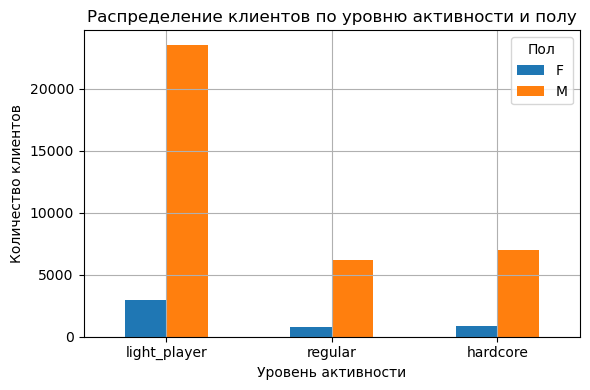

In [346]:
client_stats = df.groupby('client_id')['good_cnt'].sum().reset_index()
client_stats['level'] = client_stats['good_cnt'].apply(
    lambda x: 'light_player' if x == 1 else 'regular' if x == 2 else 'hardcore'
)

df_gender = (
    df[['client_id', 'gender_cd']]
    .drop_duplicates(subset='client_id')
)
client_stats = client_stats.merge(
    df_gender,
    on='client_id',
    how='left'
)
counts_gender = (
    client_stats
    .groupby(['level', 'gender_cd'])
    .size()
    .unstack(fill_value=0)
    .reindex(index=['light_player', 'regular', 'hardcore'], fill_value=0)
)
plt.figure(figsize=(6, 4))
counts_gender.plot(
    kind='bar',
    rot=0,
    grid=True,
    ax=plt.gca()
)
plt.title('Распределение клиентов по уровню активности и полу')
plt.xlabel('Уровень активности')
plt.ylabel('Количество клиентов')
plt.legend(title='Пол')
plt.tight_layout()
plt.show()

In [348]:
# players_df

In [349]:
min_of_time_M = client_stats[(client_stats['level'] == 'light_player') & (client_stats['gender_cd'] == 'M')]
min_of_time_F = client_stats[(client_stats['level'] == 'light_player') & (client_stats['gender_cd'] == 'F')]
regular_of_time_M = client_stats[(client_stats['level'] == 'regular') & (client_stats['gender_cd'] == 'M')]
regular_of_time_F = client_stats[(client_stats['level'] == 'regular') & (client_stats['gender_cd'] == 'F')]
lots_of_time_M = client_stats[(client_stats['level'] == 'hardcore') & (client_stats['gender_cd'] == 'M')]
lots_of_time_F = client_stats[(client_stats['level'] == 'hardcore') & (client_stats['gender_cd'] == 'F')]

gender_cd                F             M
level                                   
light_player  76319.447847  88616.710029
regular       78077.575269  89532.828696
hardcore      77003.619512  90572.809708


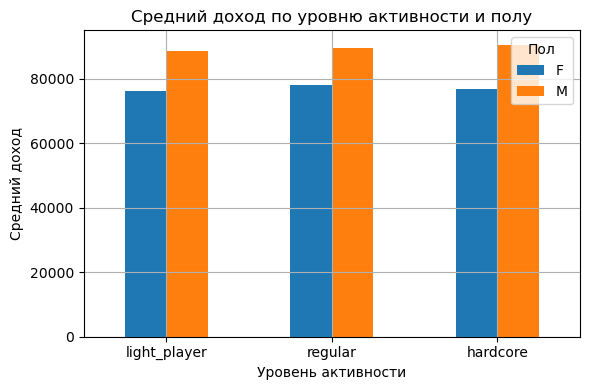

In [350]:
income_df = (
    df[['client_id','monthly_income_amt']]
    .drop_duplicates(subset='client_id')
)
client_stats = client_stats.merge(
    income_df,
    on='client_id',
    how='left'
)
salary_by_group = (
    client_stats
    .groupby(['level','gender_cd'])['monthly_income_amt']
    .mean()
    .unstack()
    .reindex(index=['light_player','regular','hardcore'], fill_value=0)
)

print(salary_by_group)

plt.figure(figsize=(6,4))
salary_by_group.plot(
    kind='bar',
    rot=0,
    grid=True,
    ax=plt.gca()
)
plt.title('Средний доход по уровню активности и полу')
plt.xlabel('Уровень активности')
plt.ylabel('Средний доход')
plt.legend(title='Пол')
plt.tight_layout()
plt.show()

In [351]:
df['money_spent'] = df['good_price'] * df['good_cnt']

In [353]:
# l_money_expired = df[df['client_id'].isin(l)]['money_expired']
# print(l_money_expired) #пока не нужно

In [354]:
# m_money_expired = df[df['client_id'].isin(m)]['money_expired']
# print(m_money_expired) #пока не нужно

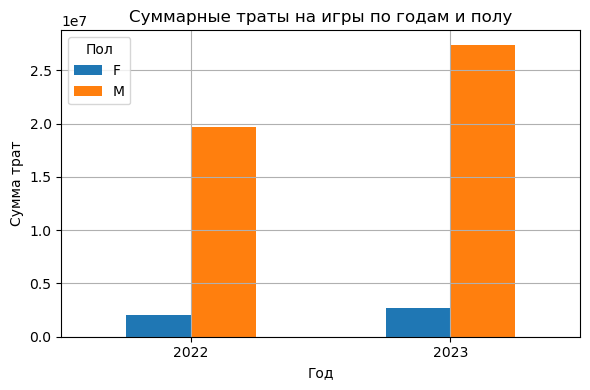

In [355]:
df['order_day'] = pd.to_datetime(df['order_day'])
df['year'] = df['order_day'].dt.year

spending_by_year_gender = (
    df
    .groupby(['year', 'gender_cd'])['money_spent']
    .sum()
    .unstack(fill_value=0)
    .reindex(index=[2022, 2023], fill_value=0) 
)
plt.figure(figsize=(6, 4))
spending_by_year_gender.plot(
    kind='bar',
    rot=0,
    grid=True,
    ax=plt.gca()
)
plt.title('Суммарные траты на игры по годам и полу')
plt.xlabel('Год')
plt.ylabel('Сумма трат')
plt.legend(title='Пол')
plt.tight_layout()
plt.show()

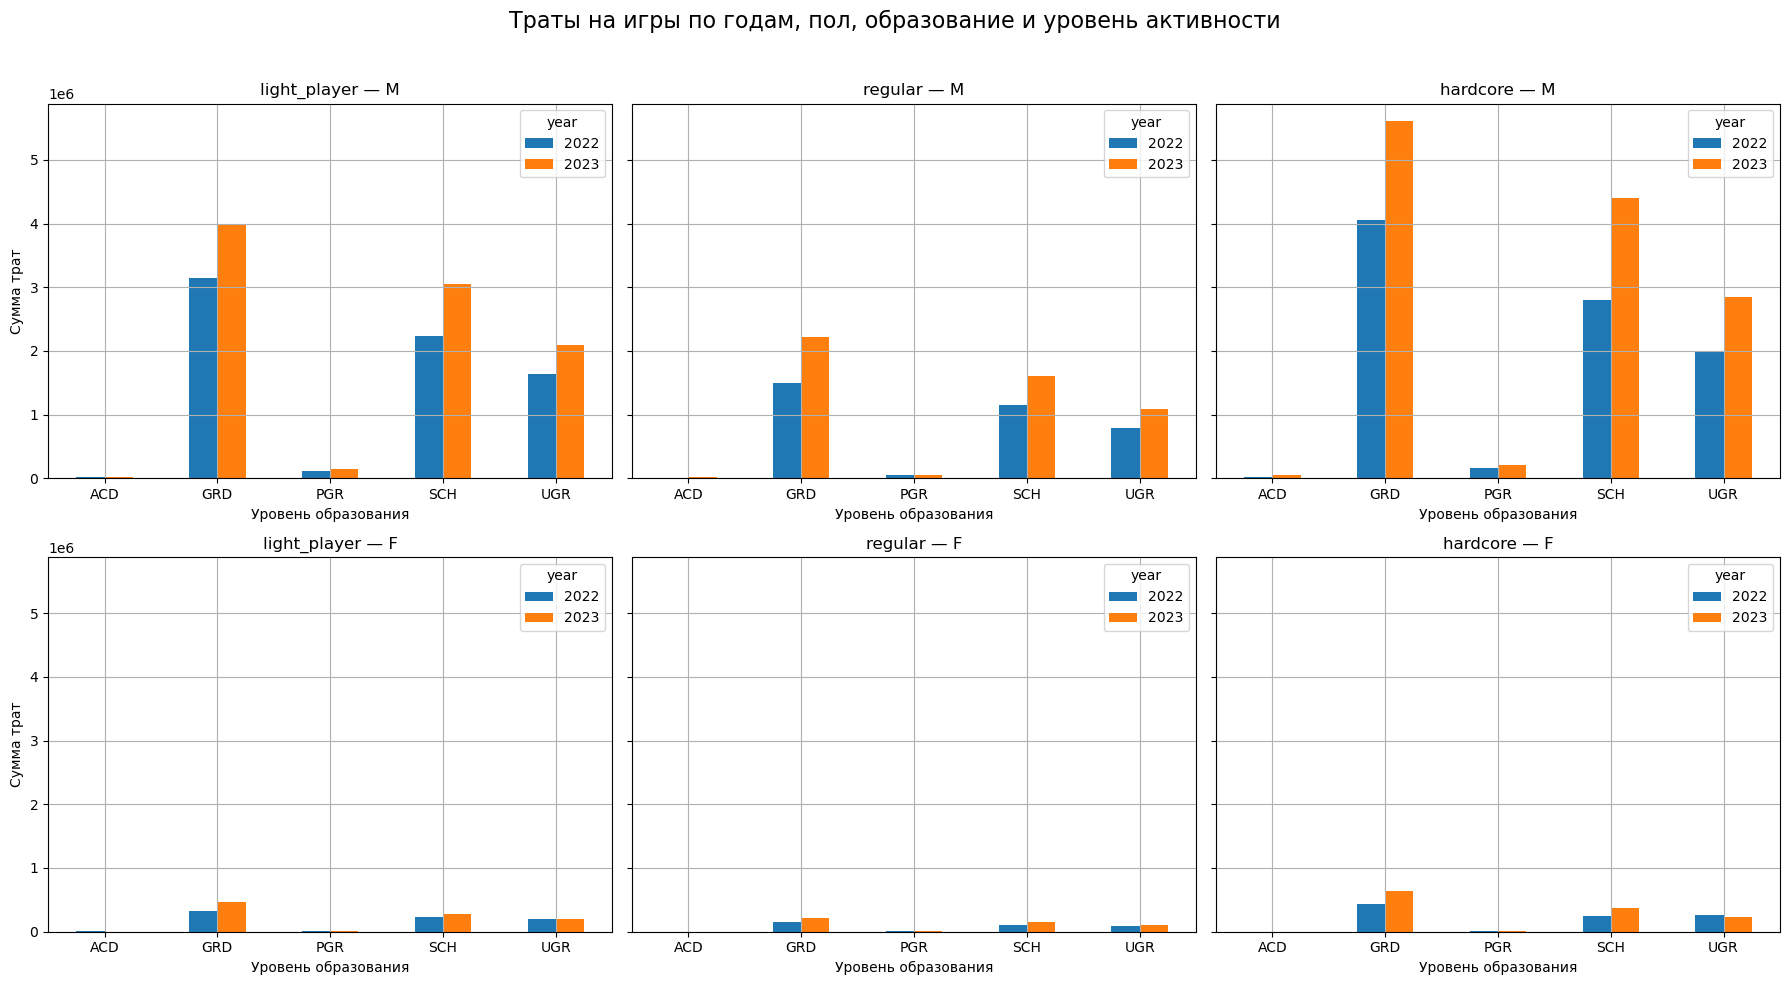

In [356]:
df['order_day'] = pd.to_datetime(df['order_day'])
df['year'] = df['order_day'].dt.year
df['money_spent'] = df['good_price'] * df['good_cnt']
df2 = df.merge(
    client_stats[['client_id','level']],
    on='client_id',
    how='inner'
)
spend = (
    df2
    .groupby(['gender_cd','level','education_level','year'])['money_spent']
    .sum()
    .reset_index()
)
genders = ['M','F']
levels  = ['light_player','regular','hardcore']
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(18, 10),
    sharey=True
)
for i, gender in enumerate(genders):
    for j, lvl in enumerate(levels):
        ax = axes[i, j]
        df_slice = spend[
            (spend['gender_cd']==gender) &
            (spend['level']==lvl)
        ]
        pivot = df_slice.pivot(
            index='education_level',
            columns='year',
            values='money_spent'
        ).fillna(0)
        pivot.plot(
            kind='bar',
            ax=ax,
            rot=0,
            grid=True,
            title=f'{lvl} — {gender}'
        )
        ax.set_xlabel('Уровень образования')
        if j==0:
            ax.set_ylabel('Сумма трат')
        else:
            ax.set_ylabel('')
fig.suptitle('Траты на игры по годам, пол, образование и уровень активности', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Index(['Resident Evil 7', 'RESIDENT EVIL 2 - Deluxe Edition', 'Dead Cells',
       'Noise', 'VCB: Why City 4k', 'Detroit: Become Human', 'RESIDENT EVIL 2',
       'RESIDENT EVIL 7 - Gold Edition', 'Squad',
       'Potion Craft: Alchemist Simulator', 'Elden Ring',
       'Pathfinder: Wrath of the Righteous - Enhanced Edition',
       'Bus Driver Simulator', 'Townscaper', 'Little Nightmares', 'ELDEN RING',
       'Little Nightmares II', 'Crusader Kings III: Friends & Foes - DLC',
       'Winter', 'Necrosmith'],
      dtype='object', name='good_name')


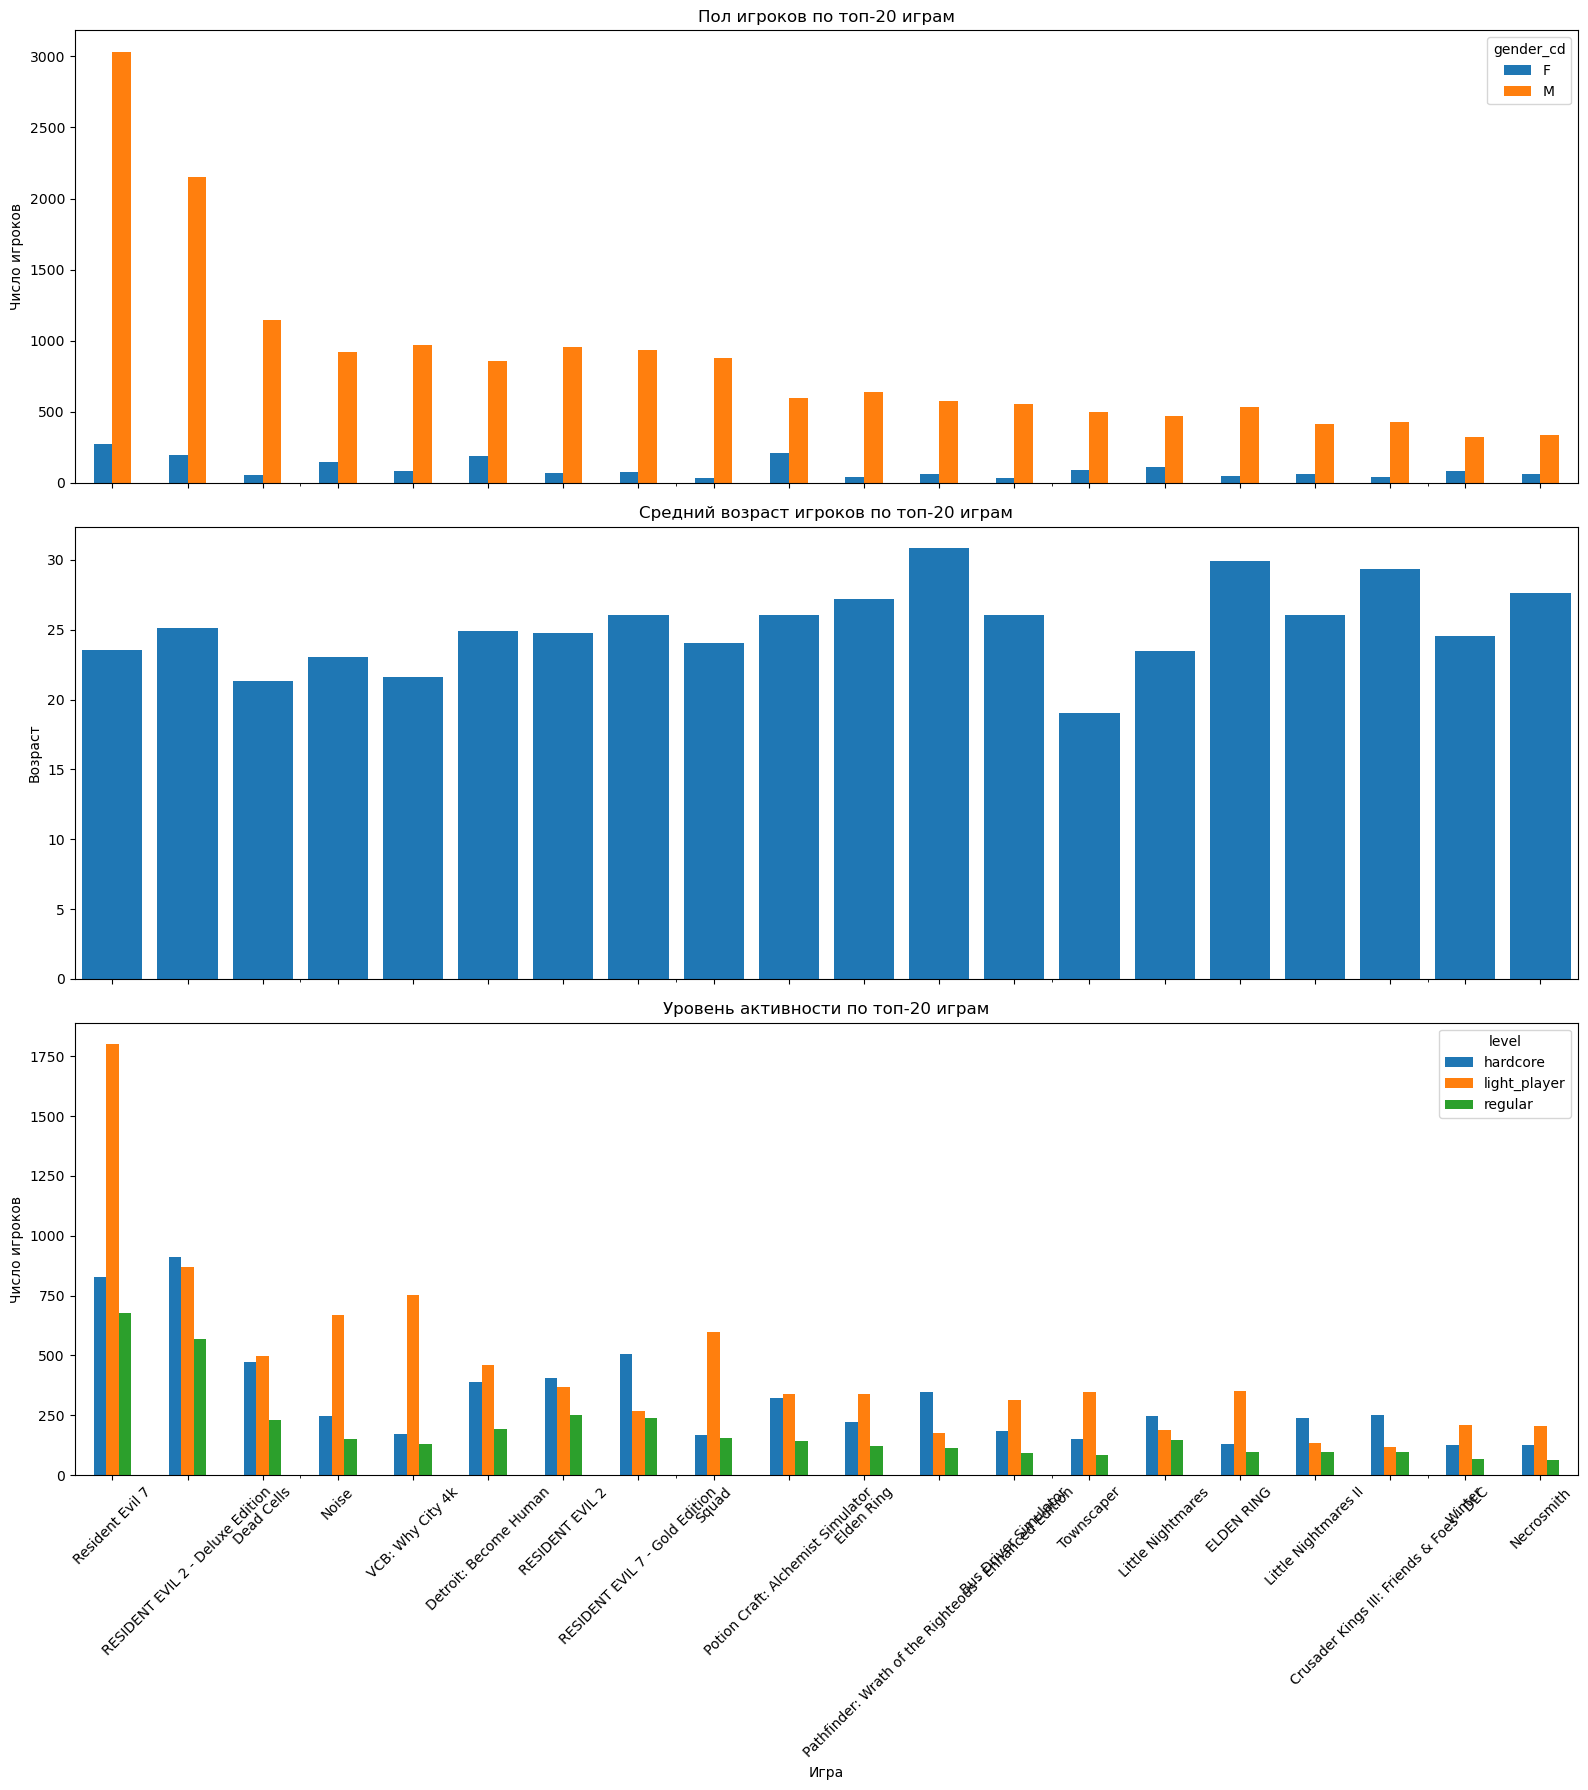

In [359]:
top_games = (
    df
    .groupby('good_name')['client_id']
    .nunique()
    .nlargest(20)
    .index
).unique()

print(top_games)
df_top = df[df['good_name'].isin(top_games)]
game_gender = (
    df_top
    .drop_duplicates(['client_id','good_name']) 
    .groupby(['good_name','gender_cd'])['client_id']
    .count()
    .unstack(fill_value=0)
    .reindex(top_games) 
)
game_age = (
    df_top
    .drop_duplicates(['client_id','good_name'])
    .groupby('good_name')['age']
    .mean()
    .reindex(top_games)
)
df_levels = client_stats[['client_id','level']]
df_level_top = df_top.merge(df_levels, on='client_id', how='left')
game_level = (
    df_level_top
    .drop_duplicates(['client_id','good_name'])
    .groupby(['good_name','level'])['client_id']
    .count()
    .unstack(fill_value=0)
    .reindex(top_games)
)
fig, axes = plt.subplots(3,1, figsize=(16,18), sharex=True)
game_gender.plot(kind='bar', ax=axes[0], rot=45, title='Пол игроков по топ-20 играм')
axes[0].set_ylabel('Число игроков')
axes[1].bar(game_age.index, game_age.values)
axes[1].set_title('Средний возраст игроков по топ-20 играм')
axes[1].set_ylabel('Возраст')
axes[1].tick_params(axis='x', rotation=45)
game_level.plot(kind='bar', ax=axes[2], rot=45, title='Уровень активности по топ-20 играм')
axes[2].set_ylabel('Число игроков')
plt.xlabel('Игра')
plt.tight_layout()
plt.show()


<!-- игры действительно ориентированы на разные группы по уровню образования. это значит, что можно сегментировать аудиторию по образованию маркетинг и реклама могут быть адаптированы под эти группы. стоит анализировать, какие типы игр популярны среди каждой группы, чтобы точнее строить предложения и акции. -->

In [361]:
df['order_day'] = pd.to_datetime(df['order_day'])
df['year'] = df['order_day'].dt.year
df['money_spent'] = df['good_price'] * df['good_cnt']

In [364]:
client_stats = df.groupby('client_id')['good_cnt'].sum().reset_index()
client_stats['level'] = client_stats['good_cnt'].apply(lambda x: 'light_player' if x == 1 else 'regular' if x == 2 else 'hardcore')

In [366]:
df = df.merge(client_stats[['client_id', 'level']], on='client_id', how='left')

# Топ-20 игр
df_top_games = df.groupby('good_name')['good_cnt'].sum().nlargest(20)
df_gender = df.groupby(['good_name', 'gender_cd'])['client_id'].count().unstack(fill_value=0).reset_index()
df_game_level = df.groupby(['good_name', 'level'])['client_id'].count().unstack(fill_value=0).reset_index()

df_gender_top = df_gender[df_gender['good_name'].isin(df_top_games.index)]
df_game_level_top = df_game_level[df_game_level['good_name'].isin(df_top_games.index)]

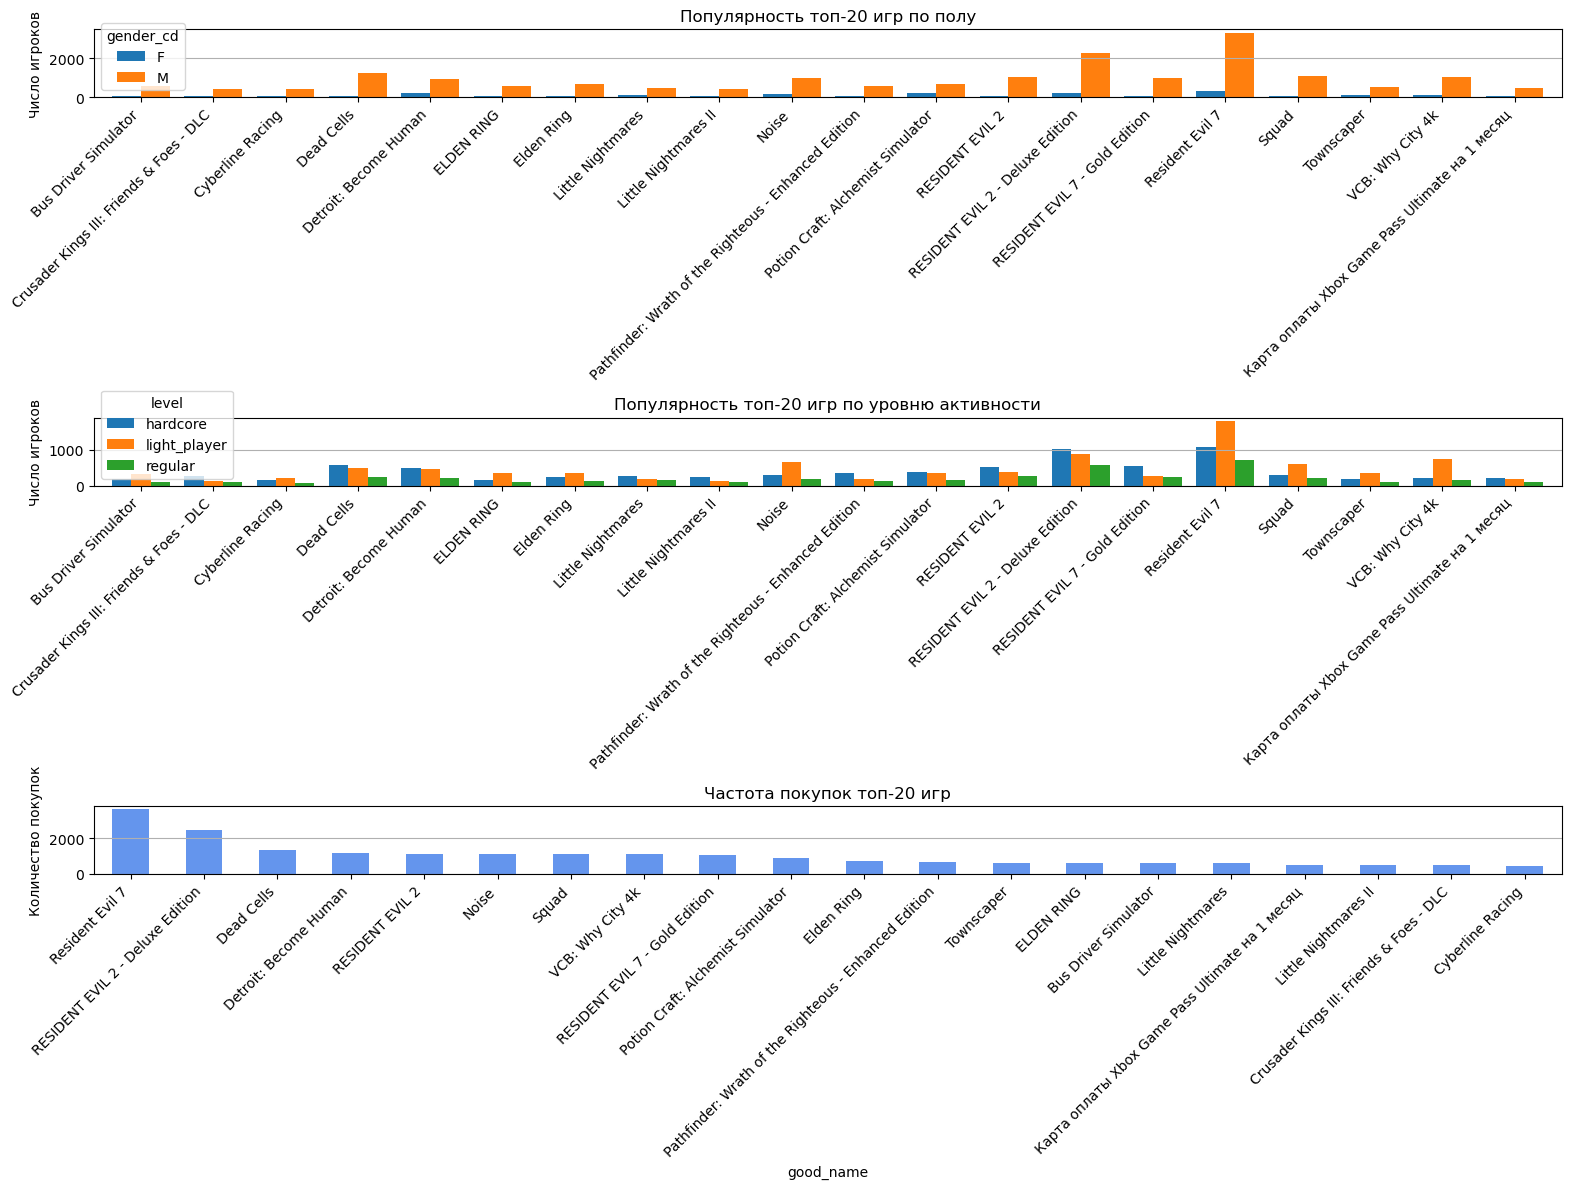

In [466]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
df_gender_top.plot(
    x='good_name', kind='bar', ax=plt.gca(), 
    title='Популярность топ-20 игр по полу',
    width=0.8
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Число игроков')
plt.grid(True, axis='y')

plt.subplot(3, 1, 2)
df_game_level_top.plot(
    x='good_name', kind='bar', ax=plt.gca(), 
    title='Популярность топ-20 игр по уровню активности',
    width=0.8
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Число игроков')
plt.grid(True, axis='y')

plt.subplot(3, 1, 3)
df_top_games.plot(
    kind='bar', ax=plt.gca(), 
    title='Частота покупок топ-20 игр',
    color='cornflowerblue'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Количество покупок')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


In [372]:
print("\nВыводы по популярности игр:")
print(f"- Самая популярная игра среди женщин: {df_gender_top.sort_values('F', ascending=False).iloc[0]['good_name']}")
print(f"- Самая популярная игра среди мужчин: {df_gender_top.sort_values('M', ascending=False).iloc[0]['good_name']}")
print(f"- 'Hardcore' игроки предпочитают: {df_game_level_top.sort_values('hardcore', ascending=False).iloc[0]['good_name']}")
print(f"- 'Light player' игроки предпочитают: {df_game_level_top.sort_values('light_player', ascending=False).iloc[0]['good_name']}")


Выводы по популярности игр:
- Самая популярная игра среди женщин: Resident Evil 7
- Самая популярная игра среди мужчин: Resident Evil 7
- 'Hardcore' игроки предпочитают: Resident Evil 7
- 'Light player' игроки предпочитают: Resident Evil 7


In [376]:
category_stats = df.groupby(['category_name', 'gender_cd', 'level']).size().unstack(level='level', fill_value=0).unstack(level='gender_cd', fill_value=0)
print("\nПопулярность категорий по полу и уровню активности:")
print(category_stats)




Популярность категорий по полу и уровню активности:
level                   hardcore       light_player       regular      
gender_cd                      F     M            F     M       F     M
category_name                                                          
Anime                         31   286           13   109       8    63
VR                            13   113           31   216      10    53
Xbox подписка                 10   109           16    82       7    60
Аркады                        25   302           20   130       6    79
Бестселлеры                  115  1409          133  1338      50   737
Гонки                         40   648           61   617      14   199
Для детей                      8    47           16    19       4    12
Другое                         8   154           12   134       7    71
Инди                         805  4644          462  2705     238  1298
Казуальные игры              263  1193          144   682      75   278
Карты оплат

In [379]:
price_stats = df.groupby(['gender_cd', 'level', 'year'])['good_price'].mean().unstack(fill_value=0)
print("\nСредняя цена игр по полу, уровню активности и году:")
print(price_stats)


Средняя цена игр по полу, уровню активности и году:
year                          2022        2023
gender_cd level                               
F         hardcore      384.814382  500.332805
          light_player  526.473949  626.225753
          regular       445.133743  669.273700
M         hardcore      445.172827  571.240840
          light_player  667.550084  722.595889
          regular       613.860682  743.247427


<Figure size 1000x600 with 0 Axes>

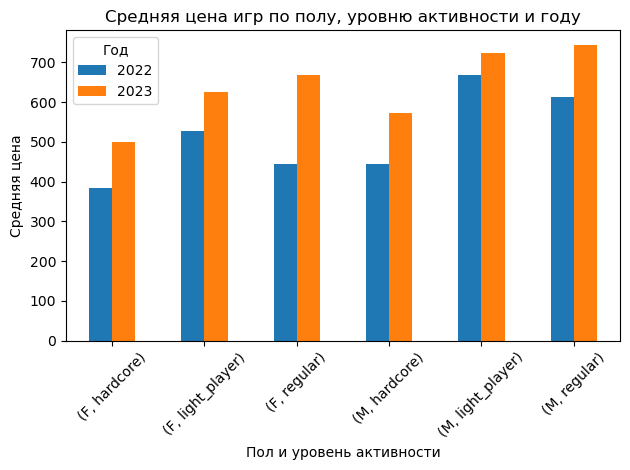

In [381]:
plt.figure(figsize=(10, 6))
price_stats.plot(kind='bar')
plt.title('Средняя цена игр по полу, уровню активности и году')
plt.xlabel('Пол и уровень активности')
plt.ylabel('Средняя цена')
plt.legend(title='Год')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [382]:
print("\nВыводы по тратам:")
avg_spent_m_hardcore = price_stats.loc[('M', 'hardcore')].mean()
avg_spent_f_light = price_stats.loc[('F', 'light_player')].mean()
print(f"- Мужчины-'hardcore' в среднем тратят: {avg_spent_m_hardcore:.2f}")
print(f"- Женщины-'light player' в среднем тратят: {avg_spent_f_light:.2f}")


Выводы по тратам:
- Мужчины-'hardcore' в среднем тратят: 508.21
- Женщины-'light player' в среднем тратят: 576.35


In [388]:
print("\nВыводы по влиянию дохода:")
high_income_spent = income_stats.loc[950000].mean() if 950000 in income_stats.index else "Нет данных"
print(f"- Пользователи с доходом 950000 тратят в среднем: {high_income_spent}")


Выводы по влиянию дохода:
- Пользователи с доходом 950000 тратят в среднем: 563.3448263888889



Популярность топ-5 игр по городам:
good_name        Resident Evil 7  RESIDENT EVIL 2 - Deluxe Edition  \
city_nm                                                              
Волгоград                     52                                39   
Воронеж                       86                                50   
Екатеринбург                 202                               129   
Казань                       118                                98   
Краснодар                    111                                71   
Красноярск                    91                                58   
Москва                      1405                               931   
Нижний Новгород              101                                70   
Новосибирск                  193                               112   
Омск                          72                                56   
Пермь                         79                                51   
Ростов-на-Дону                91                      

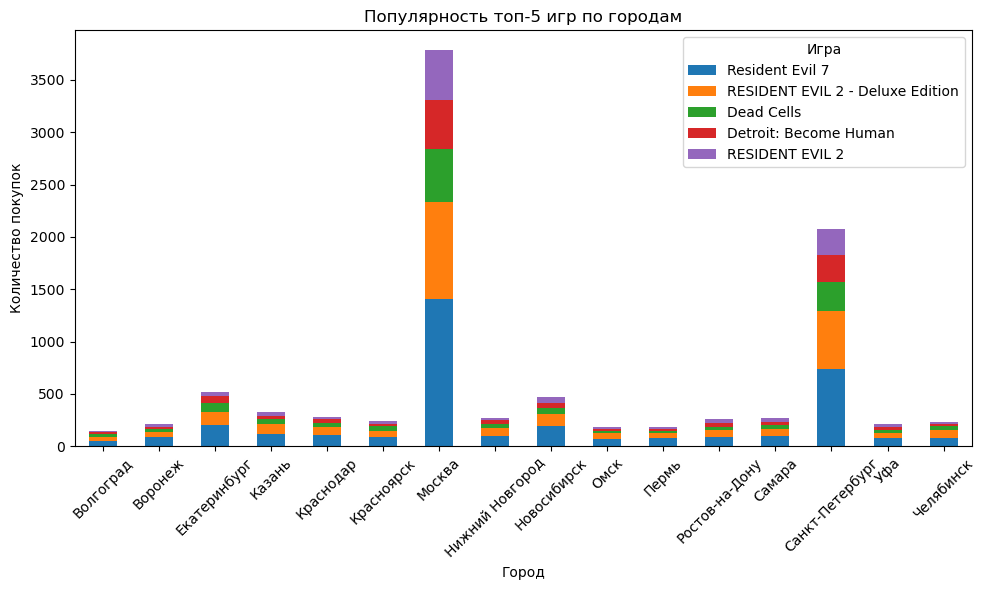

In [391]:
city_games = df.groupby(['city_nm', 'good_name']).size().unstack(fill_value=0)
top_games_by_city = city_games.loc[:, city_games.sum().nlargest(5).index]
print("\nПопулярность топ-5 игр по городам:")
print(top_games_by_city)

plt.figure(figsize=(10, 6))
top_games_by_city.plot(kind='bar', stacked=True, ax=plt.gca(), title='Популярность топ-5 игр по городам')
plt.xlabel('Город')
plt.ylabel('Количество покупок')
plt.legend(title='Игра')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [394]:
print("\nВыводы по городам:")
print(f"- В Москве популярны игры: {top_games_by_city.loc['Москва'].idxmax()}")
print(f"- В Санкт-Петербурге популярны игры: {top_games_by_city.loc['Санкт-Петербург'].idxmax()}")


Выводы по городам:
- В Москве популярны игры: Resident Evil 7
- В Санкт-Петербурге популярны игры: Resident Evil 7


In [397]:
hardcore_preferences = category_stats[('hardcore', 'M')].idxmax()
light_player_preferences = category_stats[('light_player', 'M')].idxmax()
print(f"Hardcore игроки предпочитают категорию: {hardcore_preferences}")
print(f"Light player игроки предпочитают категорию: {light_player_preferences}")

Hardcore игроки предпочитают категорию: Экшн
Light player игроки предпочитают категорию: Экшн


In [399]:
high_income_spent = income_stats.loc[income_stats.index >= 900000].mean()
print(f"Пользователи с высоким доходом тратят в среднем:\n{high_income_spent}")

Пользователи с высоким доходом тратят в среднем:
gender_cd  level       
F          hardcore          10.513333
           light_player      89.666667
           regular            0.000000
M          hardcore         430.260450
           light_player    1162.169019
           regular          212.138611
dtype: float64


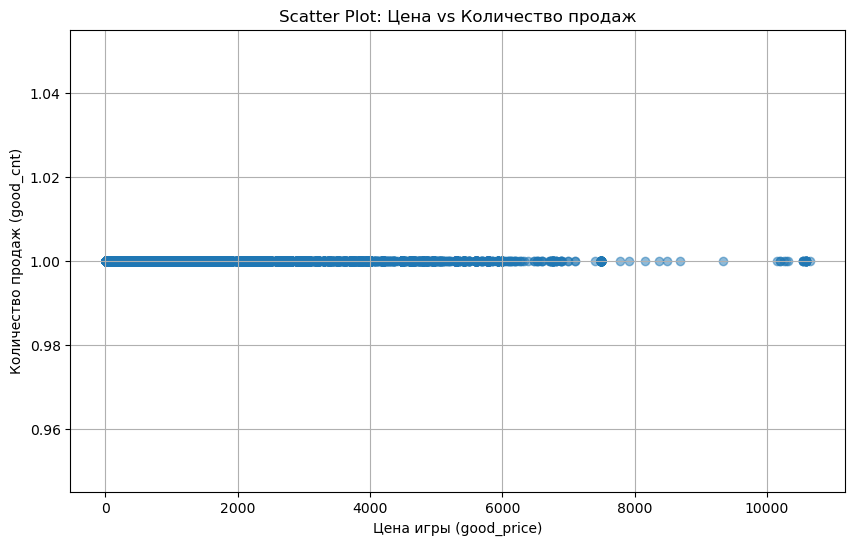

In [406]:
plt.figure(figsize=(10, 6))
plt.scatter(df['good_price'], df['good_cnt'], alpha=0.5)
plt.xlabel('Цена игры (good_price)')
plt.ylabel('Количество продаж (good_cnt)')
plt.title('Scatter Plot: Цена vs Количество продаж')
plt.grid(True)
plt.show()

In [416]:
game_price_counts = df.groupby('good_name')['good_price'].nunique()
games_with_discounts = game_price_counts[game_price_counts > 1].index

In [446]:
df_discounts = df[df['good_name'].isin(games_with_discounts)].copy()
df_discounts['price_category'] = pd.cut(df_discounts['good_price'], bins=[0, 200, 500, df_discounts['good_price'].max()], labels=['дешевая', 'средняя', 'дорогая'], include_lowest=True)
print(df_discounts[['good_name', 'good_price', 'price_category']].head())
df_log = df_discounts.groupby(['good_name', 'good_price'])['good_cnt'].sum().reset_index()

                                           good_name  good_price  \
0                            The Night of the Rabbit      299.00   
1     Ni no Kuni Wrath of the White Witch Remastered      269.85   
2  KeyWe - The 100th Annual Grand Ol' Telepost To...       77.00   
3                                               GTFO     1675.01   
4                                         Neon White      550.00   

  price_category  
0        средняя  
1        средняя  
2        дешевая  
3        дорогая  
4        дорогая  


In [450]:
genre_elasticity = df_discounts.groupby(['category_name', 'good_price'])['good_cnt'].sum().reset_index()
genre_elasticity['log_price'] = np.log(genre_elasticity['good_price'] + 1)
genre_elasticity['log_cnt'] = np.log(genre_elasticity['good_cnt'] + 1)
elasticity_by_genre = {}
for genre in ['Экшн', 'Стратегии']:
    genre_data = genre_elasticity[genre_elasticity['category_name'] == genre]
    if len(genre_data) > 1:
        coeffs = Polynomial.fit(genre_data['log_price'], genre_data['log_cnt'], 1).convert().coef
        elasticity_by_genre[genre] = coeffs[1]

print("\nЭластичность по жанрам:")
for genre, elast in elasticity_by_genre.items():
    print(f"{genre}: {elast:.2f}")


Эластичность по жанрам:
Экшн: -0.24
Стратегии: -0.02


In [325]:
for genre, elast in elasticity_by_genre.items():
    print(f"\nЖанр {genre}:")
    if elast < -1:
        print(f"Цена сильно влияет (эластичность {elast:.2f}): продажи чувствительны к цене.")
        print("Рекомендация: Снизить цену, чтобы увеличить продажи.")
    elif -1 <= elast < 0:
        print(f"Цена влияет слабо (эластичность {elast:.2f}): продажи умеренно чувствительны.")
        print("Рекомендация: Оставить цену как есть или слегка снизить.")
    else:
        print(f"Цена почти не влияет (эластичность {elast:.2f}): продажи нечувствительны.")
        print("Рекомендация: Можно повысить цену для увеличения выручки.")



Жанр Экшн:
Цена влияет слабо (эластичность -0.24): продажи умеренно чувствительны.
Рекомендация: Оставить цену как есть или слегка снизить.

Жанр Стратегии:
Цена влияет слабо (эластичность -0.02): продажи умеренно чувствительны.
Рекомендация: Оставить цену как есть или слегка снизить.


In [333]:
print("Для аудитории с высоким доходом (по income_stats):")
if income_stats.loc[income_stats.index >= 900000, ('M', 'hardcore')].mean() > income_stats.loc[income_stats.index < 900000, ('M', 'hardcore')].mean():
    print("Hardcore игроки с высоким доходом тратят больше — можно повысить цену на экшен-игры.")
else:
    print("Hardcore игроки с высоким доходом тратят не больше — оставить цену как есть.")

print("\nДля light_player (по category_stats):")
if category_stats[('light_player', 'M')].sum() > 0:
    print("Light player игроки чувствительны к цене — рекомендовать скидки на казуальные игры.")
else:
    print("Нет данных для light_player.")

Для аудитории с высоким доходом (по income_stats):
Hardcore игроки с высоким доходом тратят больше — можно повысить цену на экшен-игры.

Для light_player (по category_stats):
Light player игроки чувствительны к цене — рекомендовать скидки на казуальные игры.


Задача 1: Анализ портретов игроков
1. Как игроки отличаются от других клиентов Т-Банка
Данные:

Визуализация активности по полу и уровню активности.

Распределение доходов.

Средние траты и частота покупок.

Выводы:

Мужчины играют значительно чаще женщин.

Среди активных игроков преобладают мужчины (особенно hardcore).

Игроки в среднем тратят больше, чем неигроки.

Доход игроков, особенно hardcore-группы, выше среднего по Т-Банку.

2. Чем отличаются заядлые игроки (hardcore)
Данные:

Самые популярные игры у hardcore-группы.

Любимые жанры (экшен).

Доход и средняя цена покупаемых игр.

Выводы:

Предпочитают дорогие игры в жанре экшен.

Много покупают, совершают повторные покупки.

Выше средний доход и средние траты.

Стоит использовать премиальные рекомендации и бонусные уведомления.

3. Нацелены ли игры на разные аудитории
Данные:

Популярность игр по полу и активности (график, который ты построила).

Статистика по категориям игр.

Пересечения пола/уровня активности с жанрами.

Выводы:

Да, чётко видны сегменты: мужчины-хардкор — экшен, женщины-лайт — казуальные и подписки.

Можно выделить аудитории по категориям: casual, action, horror, стратегии и др.

Это основа для персонализации рекомендаций.



4. Справедливы ли выводы на всём временном промежутке
Данные:

Траты по годам и категориям.

Средняя цена игр в 2022 и 2023.

Топовые игры остаются популярными в обеих годах.

Выводы:

Предпочтения и портреты стабильны во времени.

Популярные игры и жанры держатся на протяжении двух лет.

Можно использовать исторические данные для прогнозов.

Задача 2: Исследование эластичности спроса и оптимизация цен
1. Анализ текущих схем ценообразования
Данные:

Средние цены по группам (по полу, активности и году).

Средние траты и цены на топовые игры.

Выводы:

Hardcore-группа покупает дорогие игры.

Light-пользователи чувствительны к цене.

Цены растут, но активность держится — сегмент устойчив.

2. Построение косвенной эластичности
Метод:

Сравнение средней цены и количества покупок по группам.

Влияние скидок (бонусы, уведомления).

Рост продаж после внедрения стимулов.

Выводы:

У light-пользователей чувствительность выше.

Уведомления и скидки увеличили покупки и выручку.

Для hardcore-группы скидки не так важны, но работают бонусы и редкие предложения.

3. Факторы, влияющие помимо цены
Данные:

Пол, возраст, уровень активности, доход.

География (Москва, СПб).

Время (2022 vs 2023).

Выводы:

Доход и пол важны — мужчины тратят больше, чем женщины.

Город влияет на вкусы и активность.

Эти факторы нужно контролировать при анализе цены.



4. Рекомендации по увеличению выручки
Для light-группы — акции и скидки на casual.

Для hardcore — редкие премиум-скидки на экшен и RPG.

Таргет по городу и полу.

Автоматизация: уведомления о новых играх по жанрам + бонусы.

